In [ ]:
#conda install pytorch torchvision -c pytorch

# Mount the drive and unzip files.

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')
!unzip sample_real_train.zip > /dev/null
!unzip sample_fake_train.zip > /dev/null


In [1]:
# heavy unzip 
!unzip pizza.zip > /dev/null

# Testing the uploaded images

100 100


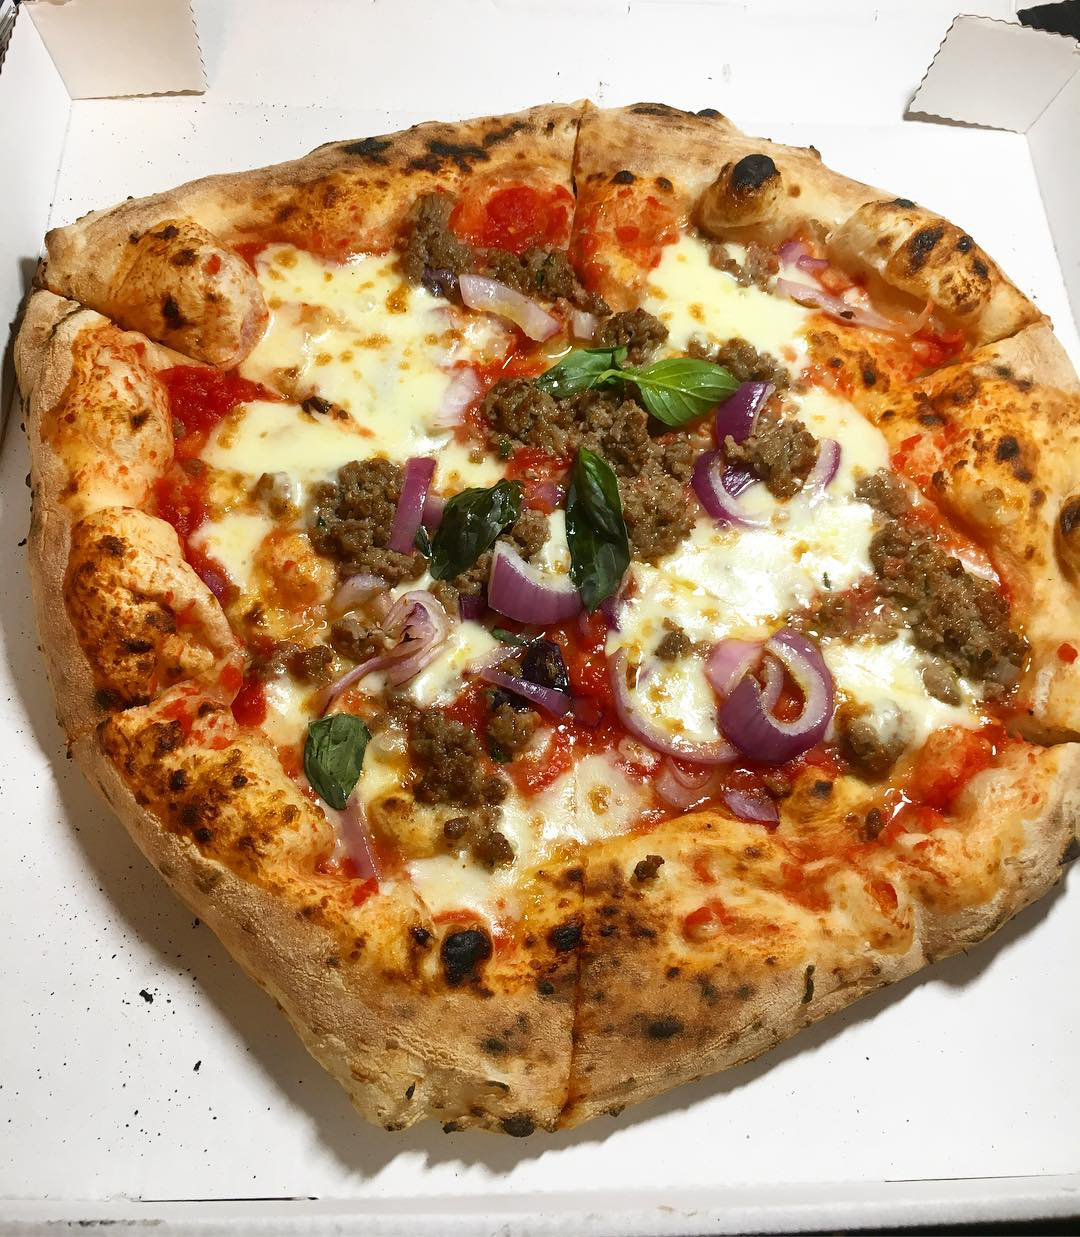

In [2]:
import os
real_train_data = './sample_real_train'
fake_train_data = './sample_fake_train'
#Number of test images(real,fake)
print(len(os.listdir(real_train_data+'/images')),len(os.listdir(fake_train_data+'/images')))

#Test to display an image
from PIL import Image 
im = Image.open(real_train_data+'/images/'+os.listdir(real_train_data+'/images')[0])  
# This method will show image in any image viewer 
im


# Getting the images and loading them.

In [3]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
image_size = 256
batch_size = 10
#stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
train_real_ds = ImageFolder(real_train_data, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
]))
train_fake_ds = ImageFolder(fake_train_data, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
]))

real_train_dl = DataLoader(train_real_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
fake_train_dl = DataLoader(train_fake_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [4]:
import numpy as np
print(len(train_real_ds))
print(len(train_real_ds[0]))
print(len(train_real_ds[0][0]))
print(len(train_real_ds[0][0][0]))
print(len(train_real_ds[0][0][0][0]))
print(train_real_ds[0][0][0][0])


100
2
3
256
256
tensor([0.8627, 0.8706, 0.8745, 0.8745, 0.8745, 0.8745, 0.8745, 0.8745, 0.8745,
        0.8745, 0.8706, 0.8706, 0.8627, 0.8549, 0.8471, 0.8510, 0.8510, 0.8588,
        0.8667, 0.8627, 0.8745, 0.8706, 0.8745, 0.8784, 0.8784, 0.8784, 0.8824,
        0.8745, 0.8745, 0.8824, 0.8863, 0.8824, 0.8627, 0.8471, 0.8588, 0.8784,
        0.8784, 0.8824, 0.8824, 0.8824, 0.8784, 0.8784, 0.8784, 0.8784, 0.8824,
        0.8863, 0.8902, 0.8902, 0.8902, 0.8902, 0.8902, 0.8902, 0.8902, 0.8863,
        0.8863, 0.8863, 0.8863, 0.8784, 0.8784, 0.8784, 0.8784, 0.8745, 0.8745,
        0.8745, 0.8745, 0.8706, 0.8745, 0.8824, 0.8510, 0.8549, 0.8667, 0.8745,
        0.8745, 0.8745, 0.8667, 0.8549, 0.8549, 0.8510, 0.8588, 0.8667, 0.8745,
        0.8745, 0.8784, 0.8824, 0.8824, 0.8784, 0.8784, 0.8824, 0.8863, 0.8863,
        0.8863, 0.8863, 0.8863, 0.8863, 0.8863, 0.8824, 0.8824, 0.8824, 0.8824,
        0.8863, 0.8863, 0.8863, 0.8863, 0.8863, 0.8863, 0.8863, 0.8863, 0.8863,
        0.8824, 0.8824, 

# Basic functions to display images

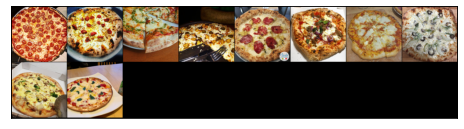

In [5]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

def denorm(img_tensors):
    return img_tensors
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images.detach()[:nmax], nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break
show_batch(real_train_dl)

# Check for gpu and load data

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
real_train_dl = DeviceDataLoader(real_train_dl, device)
fake_train_dl = DeviceDataLoader(fake_train_dl, device)

# Discriminator

In [7]:
import torch.nn as nn

In [8]:
# Discriminator architecture from J. Johnson, A. Alahi, and L. Fei-Fei, “Perceptual losses for real-time style transfer and super-resolution,” in ECCV, 2016.
# C64 − C128 − C256 − C512

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # C64 − C128 − C256 − C512
        self.c64 = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.c128 = nn.Sequential(
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(128, affine=True),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.c256 = nn.Sequential(
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(256, affine=True),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.c512 = nn.Sequential(
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(512, affine=True),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.c1=nn.Sequential(
            nn.Conv2d(512, 1, kernel_size=4, stride=5, padding=0, bias=False),
            nn.Flatten(),
            nn.Sigmoid())
        
    def forward(self, x):
        #print(x.size())
        x = self.c64(x)
        x = self.c128(x)
        x = self.c256(x)
        x = self.c512(x)
        x= self.c1(x)
        return x
        

In [9]:
discriminator = to_device(Discriminator(), device)

# Generator

In [10]:
# genarator architecture from J. Johnson, A. Alahi, and L. Fei-Fei, “Perceptual losses for real-time style transfer and super-resolution,” in ECCV, 2016.
# c7s1 − 64,d128,d256,R256,R256,R256,R256,R256,R256,R256,R256,R256,u128,u64,c7s1

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # c7s1 − k denote a 7 × 7 Convolution-InstanceNorm-ReLU layer with k filters and stride 1.
        self.c7s1_64 = nn.Sequential(
            nn.Conv2d(1, 64, 7, 1, 3, bias=False),
            nn.InstanceNorm2d(64, affine=True),
            nn.ReLU(True)
        )
        self.c7s1_3 = nn.Sequential(
            nn.Conv2d(64, 3, 7, 1, 3, bias=False),
            nn.InstanceNorm2d(3, affine=True),
            nn.ReLU(True)
        )

  # d denotes a 3 × 3 Convolution-InstanceNorm-ReLU layer with 64 filters and stride 2.
        self.d128 = nn.Sequential(
            nn.Conv2d(64, 128, 3, 2, 1, bias=False),
            nn.InstanceNorm2d(128, affine=True),
            nn.ReLU(True)
        )

    # d256 denotes a 3 × 3 Convolution-InstanceNorm-ReLU layer with k filters and stride 2.
        self.d256 = nn.Sequential(
            nn.Conv2d(128, 256, 3, 2, 1, bias=False),
            nn.InstanceNorm2d(256, affine=True),
            nn.ReLU(True)
            #stride 2
        )

        # Rk denotes a residual block that contains two 3 × 3 convolutional layers with the same number of filters on both layer.    
        self.R256 = nn.Sequential(
            nn.Conv2d(256, 256, 3, 1, 1, bias=False),
            nn.InstanceNorm2d(256, affine=True),
            nn.ReLU(True),
            nn.Conv2d(256, 256, 3, 1, 1, bias=False),
            nn.InstanceNorm2d(256, affine=True),
            nn.ReLU(True)
        )
    # uk denotes a 3 × 3 fractional-strided-ConvolutionInstanceNorm-ReLU layer with k filters and stride 1/2.
        self.u128 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, 2, 1, 1, bias=False),
            nn.InstanceNorm2d(128, affine=True),
            nn.ReLU(True)
            #stride 1/2
        )             
    # u64 denotes a 3 × 3 fractional-strided-ConvolutionInstanceNorm-ReLU layer with k filters and stride 1/2.
        self.u64 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, 2, 1, 1, bias=False),
            nn.InstanceNorm2d(64, affine=True),
            nn.ReLU(True)
            #stride 1/2
        )

    def forward(self, x):
        #import pdb;pdb.set_trace()
        x = self.c7s1_64(x)
        x = self.d128(x)
        x = self.d256(x)
        # 9 times residual block
        for i in range(9):
            x = self.R256(x)
        # u128
        x = self.u128(x)
        # u64
        x=  self.u64(x)
        # c7s1
        x = self.c7s1_3(x)
        return x

In [11]:
generator = Generator()
generator = to_device(generator, device)

In [ ]:
# test generator
# first create a generator

# then test it
# generate a random noise
z = torch.randn(batch_size, 1, 256, 256)
z=z.to(device)
# generate a fake image
fake_image = generator(z)
# show the fake image

print(fake_image.shape)
#show_images(fake_image)



# Discriminator Training

In [21]:
from tqdm.notebook import tqdm
import torch.nn.functional as F
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    #print('Real')
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    #print(real_preds.size(),real_targets.size())
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    sample=torch.randn(batch_size, 1, 128, 128, device=device)
    sample=sample.to(device)
    fake_images = generator(sample)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    #print('fake')
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

# Generator Training

In [22]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    sample=torch.randn(batch_size, 1, 128, 128, device=device)
    sample=sample.to(device)
    fake_images = generator(sample)
    
    # Try to fool the discriminator
    #print('generator')
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

# Save generated images

In [23]:
from torchvision.utils import save_image
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)


# Training loop

In [24]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    loss_g=0
    loss_d=0
    real_score=0
    fake_score=0
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(real_train_dl):
            #print(len(real_images))
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        #save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [25]:
lr = 0.0002
epochs = 25
history = fit(epochs, lr)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/25], loss_g: 3.9134, loss_d: 0.3651, real_score: 0.9062, fake_score: 0.2276


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [2/25], loss_g: 8.0374, loss_d: 0.1083, real_score: 0.9714, fake_score: 0.0743


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [3/25], loss_g: 8.0528, loss_d: 0.0938, real_score: 0.9906, fake_score: 0.0798


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [4/25], loss_g: 9.3201, loss_d: 0.0295, real_score: 0.9717, fake_score: 0.0002


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [5/25], loss_g: 18.6253, loss_d: 0.0180, real_score: 0.9829, fake_score: 0.0000


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [6/25], loss_g: 7.7167, loss_d: 0.0855, real_score: 0.9995, fake_score: 0.0813


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [7/25], loss_g: 12.1610, loss_d: 0.0550, real_score: 0.9963, fake_score: 0.0499


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [8/25], loss_g: 14.0907, loss_d: 0.0562, real_score: 0.9973, fake_score: 0.0520


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [9/25], loss_g: 6.0249, loss_d: 0.0030, real_score: 0.9995, fake_score: 0.0025


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [10/25], loss_g: 6.5880, loss_d: 0.0132, real_score: 0.9973, fake_score: 0.0104


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [11/25], loss_g: 11.3855, loss_d: 0.0196, real_score: 0.9817, fake_score: 0.0001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [12/25], loss_g: 6.7533, loss_d: 0.0116, real_score: 0.9992, fake_score: 0.0107


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [13/25], loss_g: 7.3958, loss_d: 0.0117, real_score: 0.9983, fake_score: 0.0100


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [14/25], loss_g: 7.5071, loss_d: 0.1477, real_score: 0.8850, fake_score: 0.0000


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [15/25], loss_g: 4.4552, loss_d: 0.0195, real_score: 1.0000, fake_score: 0.0186


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [16/25], loss_g: 6.8353, loss_d: 0.0444, real_score: 0.9999, fake_score: 0.0429


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [17/25], loss_g: 6.7750, loss_d: 0.0513, real_score: 1.0000, fake_score: 0.0494


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [18/25], loss_g: 6.5690, loss_d: 0.0031, real_score: 0.9998, fake_score: 0.0029


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [19/25], loss_g: 5.9117, loss_d: 0.0529, real_score: 0.9872, fake_score: 0.0383


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [20/25], loss_g: 8.0793, loss_d: 0.0084, real_score: 0.9921, fake_score: 0.0002


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [21/25], loss_g: 12.2878, loss_d: 0.2107, real_score: 0.8452, fake_score: 0.0000


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [22/25], loss_g: 5.4243, loss_d: 0.4472, real_score: 0.9959, fake_score: 0.3294


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [23/25], loss_g: 4.8434, loss_d: 0.2845, real_score: 0.8941, fake_score: 0.0433


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [24/25], loss_g: 5.5844, loss_d: 0.0696, real_score: 0.9466, fake_score: 0.0112


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [25/25], loss_g: 5.5713, loss_d: 0.3570, real_score: 0.7973, fake_score: 0.0024


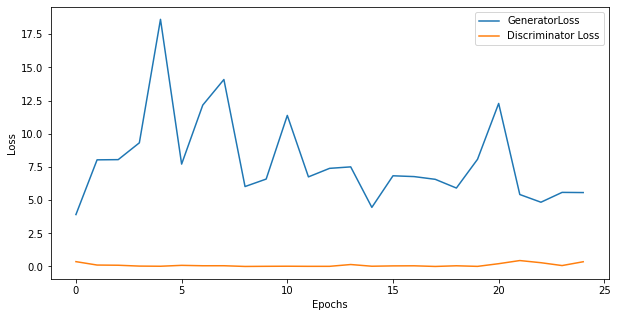

In [26]:
#plot history 
#plot losses
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(history[0], label='GeneratorLoss')
plt.plot(history[1], label='Discriminator Loss')
# label the plot
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()
plt.show()